In [6]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving fra.txt to fra.txt
User uploaded file "fra.txt" with length 10200867 bytes


In [7]:
from keras.models import Model
from keras.layers import Input, CuDNNLSTM, Dense
import numpy as np
from numpy.random import seed
seed(1)

from tensorflow import set_random_seed
set_random_seed(2)

Using TensorFlow backend.


In [0]:
batch_size = 64
epochs = 100
num_samples = 10000
data = 'fra.txt'

In [0]:
import numpy as np
import pandas as pd
df = pd.read_csv(data,delimiter='\t')

In [10]:
df.head(10)

,Go.,Va !
0,Run!,Cours !
1,Run!,Courez !
2,Wow!,Ça alors !
3,Fire!,Au feu !
4,Help!,À l'aide !
5,Jump.,Saute.
6,Stop!,Ça suffit !
7,Stop!,Stop !
8,Stop!,Arrête-toi !
9,Wait!,Attends !


In [0]:
del df

**Vactorizing data**

In [15]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

# Loop over lines
lines = open(data).read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
  # Input and target are split by tabs
    # English TAB French
    input_text, target_text = line.split('\t')
    
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    # Create a set of all unique characters in the input
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
            
    # Create a set of all unique output characters
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

print('Number of samples:', len(input_texts))


    
  
  

Number of samples: 10000


In [16]:
input_characters = sorted(list(input_characters)) # Make sure we achieve the same order in our input chars

target_characters = sorted(list(target_characters))

num_encoder_tokens = len(input_characters) # size of the english alphabate + numbers + signs etc
num_decoder_tokens = len(target_characters) # size of the french alpahbate+ numbers, signs etc

print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)

Number of unique input tokens: 71
Number of unique output tokens: 93


In [0]:
# workds as similar to tokenizer
# the index maps a character to a number
input_token_index = {char: i for i, char in enumerate(input_characters)}
target_token_index = {char: i for i, char in enumerate(target_characters)}

In [18]:
# Demo character tokenization
for c in 'the cat sits on the mat':
  print(input_token_index[c], end= ' ')

63 51 48 0 46 44 63 0 62 52 63 62 0 58 57 0 63 51 48 0 56 44 63 

In [19]:
max_encoder_seq_length = max([len(txt) for txt in input_texts]) # Get longest sequence length
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Max sequence length for inputs: 16
Max sequence length for outputs: 59


In [0]:
# encoder_input_data is a 3D array of shape (num_pairs, max_english_sentence_length, num_english_characters) 
# containing a one-hot vectorization of the English sentences.

encoder_input_data = np.zeros(

    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32'
)

# decoder_input_data is a 3D array of shape (num_pairs, max_french_sentence_length, num_french_characters) 
# containg a one-hot vectorization of the French sentences.

decoder_input_data = np.zeros(

    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32'
)
# decoder_target_data is the same as decoder_input_data but offset by one timestep. 
# decoder_target_data[:, t, :] will be the same as decoder_input_data[:, t + 1, :]
decoder_target_data = np.zeros(

    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype= 'float32'
 )


In [0]:
# Loop over input texts
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
  # Loop over each char in an input text
  for t, char in enumerate(input_text):
    
    encoder_input_data[i, t, input_token_index[char]] = 1
    
    for t, char in enumerate(target_text):
      
      # decoder_target_data is ahead of decoder_input_data by one timestamp
      decoder_input_data[i, t, target_token_index[char]] =1
      
      if t>0:
        decoder_target_data[i, t-1, target_token_index[char]]=1
      

In [24]:
# Define input sequence and process it

latent_dim = 256

encoder_inputs = Input(shape=(None, num_encoder_tokens), 
                       name = 'encoder_inputs')

# The return_state contructor argument, configuring a RNN layer to return a list 
# where the first entry is the outputs and the next entries are the internal RNN states. 
# This is used to recover the states of the encoder.
encoder = CuDNNLSTM(latent_dim, 
                    return_state=True, 
                    name = 'encoder')

encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens), 
                       name = 'decoder_inputs')

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = CuDNNLSTM(latent_dim, 
                         return_sequences=True, 
                         return_state=True, 
                         name = 'decoder_lstm')
# The inital_state call argument, specifying the initial state(s) of a RNN. 
# This is used to pass the encoder states to the decoder as initial states.
# Basically making the first memory of the decoder the encoded semantics
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = Dense(num_decoder_tokens, 
                      activation='softmax', 
                      name = 'decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)







                    

W0729 06:34:15.933761 140384830613376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [25]:
# Run training
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy')
history = model.fit([encoder_input_data, decoder_input_data],
                   decoder_target_data,
                   batch_size=batch_size,
                   epochs = epochs,
                   validation_split = 0.2)

W0729 06:36:10.981978 140384830613376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0729 06:36:11.006561 140384830613376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0729 06:36:11.127177 140384830613376 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0729 06:36:11.426393 140384830613376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 10s 1ms/step - loss: 0.9274 - val_loss: 0.9817
Epoch 2/100
8000/8000 [==============================] - 2s 216us/step - loss: 0.7432 - val_loss: 0.8001
Epoch 3/100
8000/8000 [==============================] - 2s 212us/step - loss: 0.6286 - val_loss: 0.7200
Epoch 4/100
8000/8000 [==============================] - 2s 216us/step - loss: 0.5722 - val_loss: 0.6641
Epoch 5/100
8000/8000 [==============================] - 2s 212us/step - loss: 0.5303 - val_loss: 0.6300
Epoch 6/100
8000/8000 [==============================] - 2s 211us/step - loss: 0.4982 - val_loss: 0.6140
Epoch 7/100
8000/8000 [==============================] - 2s 213us/step - loss: 0.4730 - val_loss: 0.5886
Epoch 8/100
8000/8000 [==============================] - 2s 214us/step - loss: 0.4508 - val_loss: 0.5748
Epoch 9/100
8000/8000 [==============================] - 2s 214us/step - loss: 0.4313 - val_loss: 0.5614
Epoch 10

Evaluate the Model

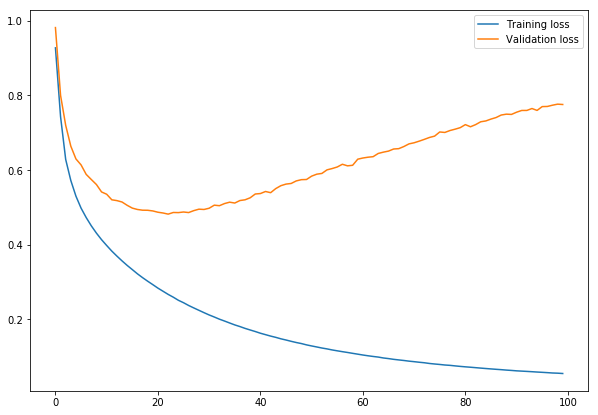

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,7))
a, = plt.plot(history.history['loss'], label='Training loss')
b, = plt.plot(history.history['val_loss'],label='Validation loss')
plt.legend(handles = [a,b])
plt.show()

In [0]:
# Define encoder model
encoder_model = Model(encoder_inputs, encoder_states)

In [0]:
# Define decoder model
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))

# Create a combined memory to input into the decoder
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Decoder
decoder_outputs, state_h, state_c = decoder_lstm(

    decoder_inputs, initial_state = decoder_states_inputs
)
decoder_states = [state_h, state_c]

# Predict next char
decoder_outputs = decoder_dense(decoder_outputs)

# The model takes in the encoder memory plus it's own memory as an input and spits out 
# a prediction plus its own memory to be used for the next char

decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                     [decoder_outputs] + decoder_states)

In [0]:
# Reverse-lookup token index to decode sequences back to 
reverse_input_char_index = {i: char for char,
                           i in input_token_index.items()}
reverse_target_char_index = {i: char for char, i in target_token_index.items()}



In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    
    # Loop untill we recieve a stop sign
    while not stop_condition:
        # Get output and internal states of the decoder 
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)
        
        # Get the predicted token (the token with the highest score)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # Get the character belonging to the token
        sampled_char = reverse_target_char_index[sampled_token_index]
        # Append char to output
        decoded_sentence += sampled_char
        
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.
        
        # Update states
        states_value = [h, c]

    return decoded_sentence




        

    
    
    

In [0]:
my_text = 'Thanks'
placeholder = np.zeros((1, len(my_text)+10, num_encoder_tokens))


In [40]:
for i, char in enumerate(my_text):
  print(i, char, input_token_index[char])
  placeholder[0,i,input_token_index[char]] = 1

0 T 38
1 h 51
2 a 44
3 n 57
4 k 54
5 s 62


In [41]:
decode_sequence(placeholder)

'Merci !\n'